Machinery for manufacturing LIBS type spectra
Current assumption is spectra will be made/persisted before training from here
Can we easily saved as .py file however for import an on the fly generation if desired

TODO: class docstrings AND Type Hints per:
https://realpython.com/documenting-python-code/
https://docs.python.org/3/library/typing.html

In [14]:
#imports and env
import numpy as np
import pickle
import math
from matplotlib import pyplot as plt
from scipy.special import voigt_profile as voigt 

datapath = "../data/"
datafile = "rel_int/top30_spec.pickle"

In [15]:
class spectrum_maker():
    #class docstring, parameters, public methods
    """ generates LPS spectra """
    #class attributes
    #First 30 elements
    avail_elem = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 
        'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']
    #Relative ppm of first 30 elements
    elem_abund = elem_abund = np.loadtxt(datapath + "abundance/abundance_94.csv")[0:30]
    
    #TODO define an environment context and specify datapath there.
    with open(datapath + datafile, 'rb') as f:
        atom_dict = pickle.load(f)
    
    #Future elements?
    """ ['Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 
        'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 
        'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 
        'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 
        'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo'] """
    
    def __init__(self, max_z: int) -> None:
        if max_z > len(self.avail_elem):
            raise ValueError(f"Currently supports only the first {len(self.avail.elem)} elements")
        self.max_z = max_z
        self.elem_abund = self.elem_abund[:max_z]
        self.elements = self.avail_elem[:max_z]
   
    #TODO reconsider if mixing dict and array style is worth it vs. strict ordered array conventions

    def peak_maker(self,
    element,
    inc=1,
    w_lo=190,
    w_hi=950,
    voigt_sig=1,#stdev of normal part of voigt convolution
    voigt_gam=1, #half-width at half max parameter of cauchy part of convolution
    shift=False,
    shift_type='random',
    shift_mean=5,
    height=False,
    height_type='random',
    height_mean=0,
    height_mag=0.001,
    plot=False):
        
        peak_loc = self.atom_dict[element][:,0]
        rel_int = self.atom_dict[element][:,1]
        if plot:
        #    plot histogram of element intensities
            plt.bar(x=peak_loc, height=rel_int, width=3,color="red")
            plt.xlabel('wavelength [nm]')
            plt.ylabel('intensity')
            plt.xlim([190, 950]) #note data may go beyond this range
            plt.show
        
        peak_count = len(rel_int)
        wave = np.arange(w_lo, w_hi, inc)
        
        # jitter peak positions and intensities
        if shift:
            if shift_type=='sys': # apply systematic peak shift
                peak_loc = peak_loc + shift_mean
            if shift=='random': # apply random peak wavelength shift, mean 0
                mag = shift_mean * (np.random.rand(peak_count) - 0.5)
                peak_loc = peak_loc + mag
        
        if height:
            if height_type=='random':
                h_mult = np.random.rand(peak_count) + 0.5 #min 0.5, mean 1.0, max 1.5
                rel_int = rel_int * h_mult
                rel_int = rel_int / np.sum(rel_int, axis=0) #re-scale to 1.0
            if height_type=='lin':
                h_add = height_mag * peak_loc + height_mean
                rel_int = np.where(rel_int + h_add < 0, 0, rel_int + h_add)
                rel_int = rel_int / np.sum(rel_int, axis=0) #re-scale to 1.0
        
        # create peaks with defined Voigt profiles from peak location and intensities derived from database
        peaks = np.array([a * voigt(wave - x, voigt_sig, voigt_gam) for a, x in zip(rel_int, peak_loc)])
        #sum the wave profiles across all the (rel_int, peak_loc) tuples, now smoothed spectra  on range w_lo:w_hi
        #scale the end result
        spec = np.sum(peaks, axis=0)
        spec = spec/np.sum(spec)
        
        if plot:
            plt.plot(wave, spec)
            plt.xlabel('wavelength [nm]')
            plt.ylabel('intensity')
            plt.xlim([190, 950])
            plt.show
        
        return wave, spec    
    
    #make_spectra provides the weighted superposition of peak_maker spectra with artifacts/noise added
    def make_spectra(self, 
        fracs, #element relative element proportion array, must be length = max_z of instance
        inc=1,
        w_lo=190, # lower limit of spectrum
        w_hi=950, # upper limit of spectrum
        artifact=False, # flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
        art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
        art_mag=0.1, # relative magnitude of artifact to spectrum intensity
        noise=False, # noise flag
        noise_type='Gaussian', # noise type
        snr=10):
        
        if len(fracs) != self.max_z:
            raise ValueError(f"First {self.max_z} elements configured, {len(fracs)} provided.")
        if not (all(x >=0 for x in fracs) and np.sum(fracs) > 0):
            raise ValueError("Element fractions must be non-negative and sum must be non-zero")
        
        #scale fractions to sum to 1.0
        fracs = fracs/np.sum(fracs)
        wave = np.arange(w_lo, w_hi, inc)
        spec_array = np.zeros((self.max_z, len(wave)))

        #gen individual element spectra and combine into weighted sum. (weighted sum should remain 1.0)
        for i in range(self.max_z): #considered np.nonzero() syntax but opaque
            if fracs[i] > 0:#only process elements with non-zero weight
        #TODO add logic here to vary peak_maker parameters randomly
        # use **kwargs to pass on parameters from this method invocation to next
                _, spec_array[i] = self.peak_maker(self.elements[i], shift=True, height=True)
                spec_array[i] = fracs[i] * spec_array[i]
        
        #aggregate the weighted spectra to componsite, figure the maximum peak, scale spectrum
        spec = np.sum(spec_array, axis=0) #note that axis is the one you are collapsing, e.g. leaves columns
        spec /= np.sum(spec)
        maximum = np.max(spec)
        
        # --- add artifacts
        art = np.zeros(len(spec))
        if artifact:
            if any([i=='const' for i in art_type]):
                art += art_mag * maximum
                
            if any([i=='square' for i in art_type]):
                lim = np.sort(np.random.choice(wave, 2))
                idx = (wave>lim[0]) * (wave<lim[1])
                sq_loc = np.where(idx)[0]
                art_scale = art_mag * maximum
                art[sq_loc] += art_scale
                
            if any([i=='Gaussian' for i in art_type]):
                #TODO check if sigma should be parametrized with method arg
                sigma = (w_hi-w_lo)*0.5
                mu = np.random.randint(w_lo,w_hi)
                bg = 100 * np.random.rand() * maximum * 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (wave - mu)**2 / (2 * sigma**2))
                art += bg
                
        spec += art
        spec_array = np.append(spec_array, np.expand_dims(art, 0), axis=0)
        # --- add noise
        noi = np.zeros(len(spec))
        if noise:
            if noise_type=='Gaussian':
                noi += np.random.normal(0, 1/snr**0.5, len(noi))
        
        #limit the net spectrum to nonnegative intensity values
        spec_array = np.append(spec_array, np.expand_dims(noi, 0), axis=0)
        spec = np.where(spec + noi < 0, 0, spec + noi)
        spec /= np.sum(spec)

        return wave, spec, spec_array
    
    def batch_spectra(self,
        focus_el=[], #optional list of specific elements within class max_z
        n_elem=4, #defines the mean number of elements included
        n_delta=2, #defines the +/- range for number of elements to vary
        abund_scale=0.5, #max variation factor on natural abundance (<=1)
        inc=1,
        w_lo=190, # lower limit of spectrum
        w_hi=950, # upper limit of spectrum
        artifact=False, # flag to include spectral artifacts ('constant', 'square', or 'Gaussian')
        art_type=['square', 'Gaussian'], # types of artifacts to be included - must be a list for now
        art_mag=0.1, # relative magnitude of artifact to spectrum intensity
        noise=False, # noise flag
        noise_type='Gaussian', # noise type
        snr=10,
        batch=16): #number of samples to create
        
        max_elem = self.max_z
        if len(focus_el):
            max_elem = len(focus_el)
            if not all (x in self.elements for x in focus_el):
                raise ValueError(f"Elements must be among the first {self.max_z}.")
        if n_elem + n_delta > max_elem:
            raise ValueError("n_elem + n_delta cannot exceed available elements") 
        if n_delta > n_elem-1:
            raise ValueError("n_delta must be less than n_elem to avoid empty samples")
        if abund_scale <0 or abund_scale >1:
            raise ValueError(f"abund_scale must lie on interval [0,1], {abund_scale} given")
        #generate the element fractions
        #first identify the number of elements that will be in each sample in the batch
        num_elem = (n_elem + np.round(2 * (n_delta+0.5) * np.random.rand(batch) - (n_delta+0.5))).astype(int)
        #next identify the elements to include
        #TODO add option for non-uniform sampling, e.g. sample appearance ~ abundance or other factor
        if len(focus_el):
            sample_el= [np.random.choice(focus_el, num_elem[i]) for i in range(batch)] #list, not array
        else:
            sample_el = [np.random.choice(self.elements, num_elem[i]) for i in range(batch)] #list, not array
        
        #with the elements selected, generate fracs arrays for make_spectra
        #note the length of fracs is determined by max_z on object instantiation
        #central proportion are based on abundance (entropic), maybe another mode for enthalpic
        #create a boolean mask to filter element abundance
        samp_mask = np.array([np.in1d(self.elements, sample_el[i]) for i in range(batch)]) #shape (batch, max_z)
        sample_abund = self.elem_abund * samp_mask #rightmost dims = max_z for broadcasting
        #with relative sample proportions set to abundance, introduce variation scaled by parameter
        sample_var = 2 * abund_scale * (np.random.rand(batch, self.max_z)-0.5)
        sample_fracs = sample_abund * (1 + sample_var)
        #scale to sum to 1.0, maybe redundant with later scaling
        fracs = sample_fracs / np.sum(sample_fracs, axis=1, keepdims=True) 

        #The goal of UNet model is prediction of spectra array from composite spectra
        wave = np.arange(w_lo,w_hi,inc) #only needed for correct length
        x_data = np.zeros((batch, len(wave)))
        y_data = np.zeros((batch, int(self.max_z+2), len(wave)))
        
        #note the wave range generated from w_lo, w_hi, inc is going to be same in each sample
        # make_spectra also returns composite spectra and array of weighted element spectra, artifacts, noise
        for i in np.arange(batch):
            wave, x_data[i], y_data[i] = self.make_spectra(fracs=fracs[i], inc=inc, w_lo=w_lo, w_hi=w_hi, 
                                                        artifact=artifact, art_type=art_type, art_mag=art_mag,
                                                        noise=noise, noise_type=noise_type,snr=snr)
        
        return fracs, wave, x_data, y_data

<function matplotlib.pyplot.show(close=None, block=None)>

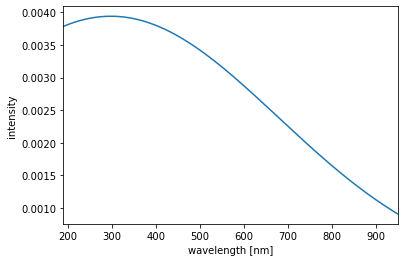

In [16]:
#explore Gaussian artifact formula
inc=1
w_lo=190 # lower limit of spectrum
w_hi=950 # upper limit of spectrum
maximum=0.1 #max relative intensity
sigma = (w_hi-w_lo) * 0.5
mu = np.random.randint(w_lo,w_hi)
wave = np.arange(w_lo,w_hi,inc)
bg = 100 * np.random.rand() * maximum * (1/(sigma * np.sqrt(2 * np.pi))) * np.exp( - (wave - mu)**2 / (2 * sigma**2))
plt.plot(wave, bg)
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


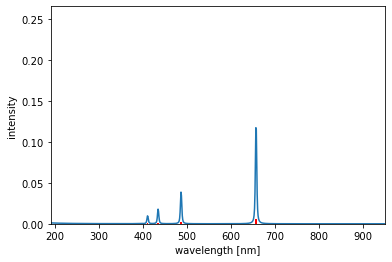

In [17]:
#Test peak maker method from class spectrum_maker
my_maker = spectrum_maker(10)
wave, spec = my_maker.peak_maker(element = "H", plot = True)
print(type(wave))
print(type(spec))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


<function matplotlib.pyplot.show(close=None, block=None)>

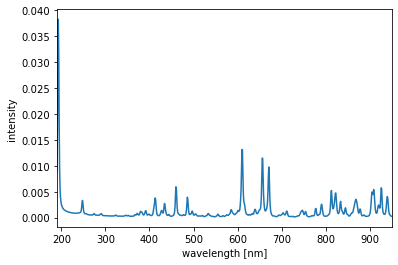

In [18]:
#Test method make_spectra from class spectrum_maker
my_maker = spectrum_maker(10)
#first 10 elements
my_elem = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne']
my_fracs = [0.1, 0, 0.2, 0, 0, 0.3, 0.2, 0.1, 0, 0.1]
my_wave, my_spec, my_specarray = my_maker.make_spectra(fracs=my_fracs)
print(type(my_wave), type(my_spec), type(my_specarray))

plt.plot(my_wave, my_spec)
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

In [19]:
#test batch_spectra method
my_maker = spectrum_maker(20)
fracs, wave, x_data, y_data = my_maker.batch_spectra()
#confirm we recover the composite spectrum from the truncated aggregation of elements+art+noise
math.isclose(np.max(abs(np.where(np.sum(y_data[0], axis=0) < 0, 0, np.sum(y_data[0], axis=0)) - x_data[0])),0)

True

In [12]:
#generate and persist large data set for model training and validation
#Note: 10,000 samples with default settings (no mods, artifacts, noise) took 6m4s or ~27/sec
#Expect 1 million to require ~10 hours which is fine since not recurring task
#However, the 10k data set takes up 1.4Gb on disk when pickled, 250Mb when compressed
#May be smart to use cloud storage for this, AWS S3 or GCP and read the data in from there for training model variants
my_maker = spectrum_maker(20)
fracs, wave, x_data, y_data = my_maker.batch_spectra(batch=1000)

In [13]:
len(fracs)

1000

In [ ]:
#persist sample data and provide code to reload elsewhere
# better ways? https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
#1M records compressed might only be ~25Gb on disk, but probably break into many files to limit RAM footprint while processing
#with open(datapath + 'my_file', 'wb') as f:
#    pickle.dump(fracs, f)
#    pickle.dump(wave, f)
#    pickle.dump(x_data, f)
#    pickle.dump(y_data, f)

#To load in other modules
#with open(datapath + 'my_file', 'rb') as f:
#    fracs = pickle.load(f)
#    wave = pickle.load(f)
#    x_data = pickle.load(f)
#    y_data = pickle.load(f)